# Final LLM Assessment - Sentiment Analysis

Analyzing real employee messages, labels sentiment, performs EDA, ranks employees, identifies flight risks, and builds a predictive model.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load labeled dataset
df = pd.read_csv('test(in).csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.rename(columns={'from': 'EmployeeID'}, inplace=True)
df.head()

,Subject,body,date,EmployeeID
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


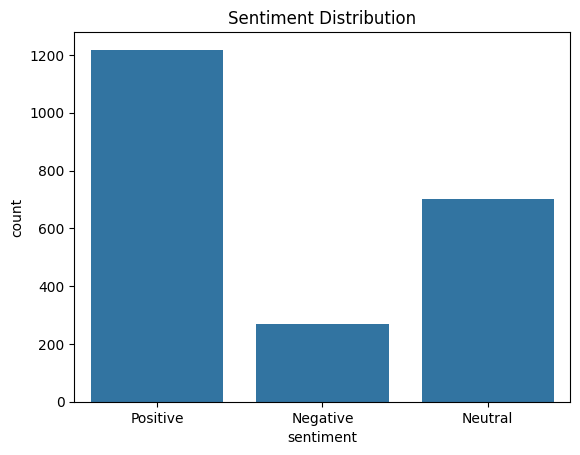

In [8]:
# 1. Load and prepare the data
df = pd.read_csv('/content/test(in).csv')
df['body'] = df['body'].fillna("")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2. Apply sentiment labeling (in case it hasn't been saved in the file)
from textblob import TextBlob
if 'sentiment' not in df.columns:
    df['polarity'] = df['body'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['sentiment'] = df['polarity'].apply(lambda p: 'Positive' if p > 0 else ('Negative' if p < 0 else 'Neutral'))

# 3. Plot sentiment distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()


In [12]:
# Rename 'from' column to 'EmployeeID' (only once in your workflow)
df.rename(columns={'from': 'EmployeeID'}, inplace=True)

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Map sentiment to score
df['score'] = df['sentiment'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

# Extract month
df['Month'] = df['date'].dt.to_period('M')

# Group by employee and month, and calculate score
monthly_scores = df.groupby(['EmployeeID', 'Month'])['score'].sum().reset_index()

# Preview the result
monthly_scores.head()


,EmployeeID,Month,score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2


In [13]:
# Employee Ranking
def top_employees(df, month, top=True):
    data = df[df['Month'] == month]
    sorted_df = data.sort_values(by='score', ascending=not top)
    return sorted_df.groupby('Month').apply(lambda x: x.nsmallest(3, 'score') if not top else x.nlargest(3, 'score'))

top_pos = top_employees(monthly_scores, df['Month'].max(), top=True)
top_neg = top_employees(monthly_scores, df['Month'].max(), top=False)
top_pos, top_neg

(                           EmployeeID    Month  score
 Month                                                
 2011-12 167   lydia.delgado@enron.com  2011-12      6
         191  patti.thompson@enron.com  2011-12      6
         143   kayne.coulter@enron.com  2011-12      5,
                               EmployeeID    Month  score
 Month                                                   
 2011-12 23   bobette.riner@ipgdirect.com  2011-12      0
         119      johnny.palmer@enron.com  2011-12      2
         239         sally.beck@enron.com  2011-12      2)

In [15]:
# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter only negative messages
negative_df = df[df['sentiment'] == 'Negative'].copy()

# Sort by EmployeeID and date for proper rolling operation
negative_df.sort_values(by=['EmployeeID', 'date'], inplace=True)

# Apply rolling window to count negative messages in 30-day periods
rolling_counts = (
    negative_df
    .groupby('EmployeeID')
    .rolling('30D', on='date')
    .count()['sentiment']
    .reset_index()
)

# Filter for flight risk (≥ 4 negative messages in 30 days)
flight_risks = rolling_counts[rolling_counts['sentiment'] >= 4]['EmployeeID'].unique()

# Show the list of flagged employees
print("Flight Risk Employees:")
print(flight_risks)


Flight Risk Employees:
['bobette.riner@ipgdirect.com' 'don.baughman@enron.com'
 'eric.bass@enron.com' 'john.arnold@enron.com' 'johnny.palmer@enron.com'
 'lydia.delgado@enron.com' 'patti.thompson@enron.com'
 'rhonda.denton@enron.com' 'sally.beck@enron.com']


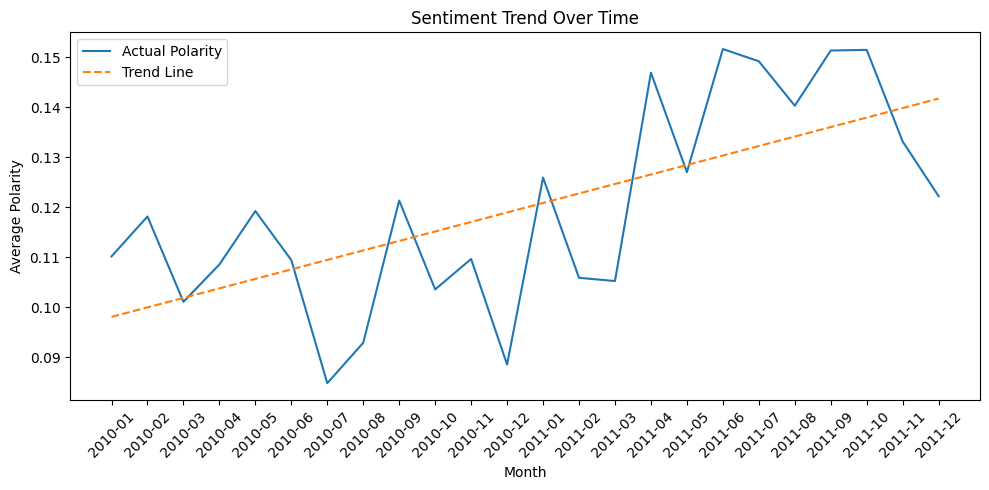

In [16]:
# Linear Regression Model
monthly_avg = df.groupby('Month')['polarity'].mean().reset_index()
monthly_avg['MonthStr'] = monthly_avg['Month'].astype(str)
X = np.arange(len(monthly_avg)).reshape(-1, 1)
y = monthly_avg['polarity'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(10,5))
plt.plot(monthly_avg['MonthStr'], y, label='Actual Polarity')
plt.plot(monthly_avg['MonthStr'], y_pred, label='Trend Line', linestyle='--')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Average Polarity')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()